# Data Setup

In [13]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 32

# 拆分100個trainset的圖片作為驗證
# train:620張圖片 / test:100張圖片
trainset = torchvision.datasets.ImageFolder(root=f'/content/drive/My Drive/2024_kaggle/train_data/', transform=transform_train)   # 會自動幫子資料夾中的圖片標籤(0,1)，站照字母順序(editada 的字母順序在real之前，因此：editada:0  real:1)
train, valid = torch.utils.data.random_split(trainset, [len(trainset)-100,100])

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size,shuffle=True, num_workers=2)

# 印出部分圖片與label

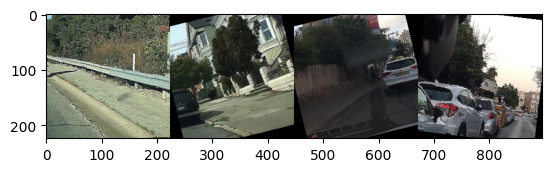

Class labels:  editada real  editada editada


In [4]:
import numpy as np

classes = ('real', 'editada')

def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

# print images and rotated images
imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Model**

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:02<00:00, 98.3MB/s]


Epoch 1/15, Loss: 0.7506
Validation Accuracy: 40.00%
Validation Loss: 0.7585
Validation loss decreased (inf --> 0.758549). Saving model...


Epoch 2/15, Loss: 0.7305
Validation Accuracy: 55.00%
Validation Loss: 0.6916
Validation loss decreased (0.758549 --> 0.691610). Saving model...


Epoch 3/15, Loss: 0.7029
Validation Accuracy: 62.00%
Validation Loss: 0.7105
EarlyStopping counter: 1 out of 3


Epoch 4/15, Loss: 0.6721
Validation Accuracy: 56.00%
Validation Loss: 0.6620
Validation loss decreased (0.691610 --> 0.661986). Saving model...


Epoch 5/15, Loss: 0.6538
Validation Accuracy: 63.00%
Validation Loss: 0.6079
Validation loss decreased (0.661986 --> 0.607914). Saving model...


Epoch 6/15, Loss: 0.6037
Validation Accuracy: 65.00%
Validation Loss: 0.5398
Validation loss decreased (0.607914 --> 0.539845). Saving model...


Epoch 7/15, Loss: 0.5079
Validation Accuracy: 87.00%
Validation Loss: 0.3630
Validation loss decreased (0.539845 --> 0.362951). Saving model...


Epoch 8/15, Loss: 0.2924
Validation Accuracy: 94.00%
Validation Loss: 0.1902
Validation loss decreased (0.362951 --> 0.190244). Saving model...


Epoch 9/15, Loss: 0.1627
Validation Accuracy: 93.00%
Validation Loss: 0.2232
EarlyStopping counter: 1 out of 3


Epoch 10/15, Loss: 0.1425
Validation Accuracy: 96.00%
Validation Loss: 0.0898
Validation loss decreased (0.190244 --> 0.089812). Saving model...


Epoch 11/15, Loss: 0.0659
Validation Accuracy: 100.00%
Validation Loss: 0.0502
Validation loss decreased (0.089812 --> 0.050169). Saving model...


Epoch 12/15, Loss: 0.0575
Validation Accuracy: 96.00%
Validation Loss: 0.1182
EarlyStopping counter: 1 out of 3


Epoch 13/15, Loss: 0.1047
Validation Accuracy: 99.00%
Validation Loss: 0.0652
EarlyStopping counter: 2 out of 3


Epoch 14/15, Loss: 0.0487
Validation Accuracy: 99.00%
Validation Loss: 0.1140
EarlyStopping counter: 3 out of 3
Early stopping


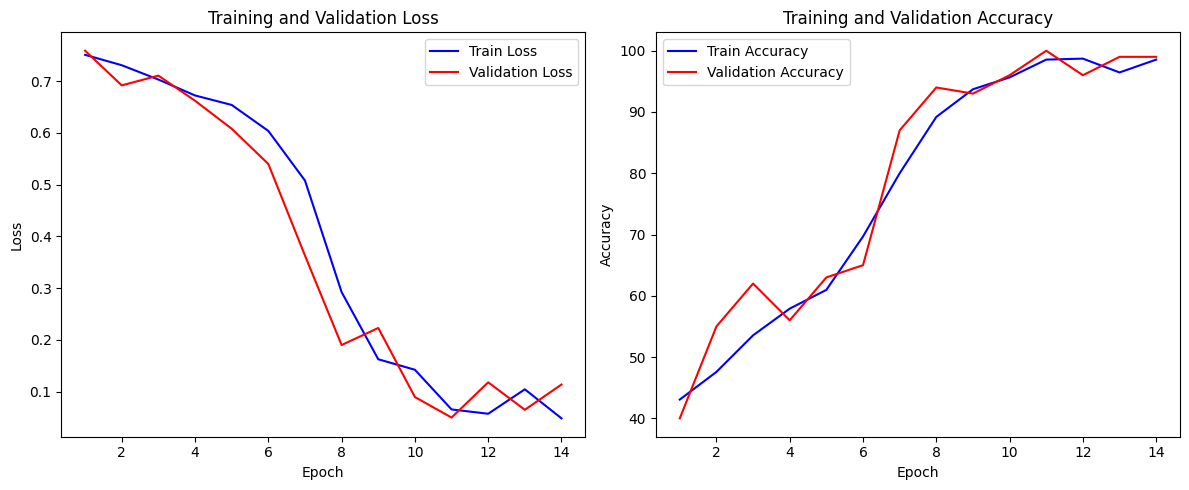

<ipython-input-14-b19e9d697f50>:208: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/2024_kaggle/best_model.pth"))


Submission file created at '/content/drive/My Drive/2024_kaggle/submission.csv'


In [14]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup
from transformers import ViTForImageClassification
from torchvision.models import swin_t

random_seed = 999
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
        self.patience = patience  #容忍的epoch數量，即驗證損失無改善的次數超過此值時停止訓練
        self.delta = delta  #最小改善幅度，小於此值視為無改善。
        self.verbose = verbose  #是否print詳細訊息，默認為 False。
        self.path = path
        self.counter = 0  #記錄驗證損失未改善的次數
        self.best_score = None  #用於記錄最佳驗證損失的負值（因為分數越高越好，所以取負）
        self.early_stop = False
        self.best_loss = float('inf')
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model):
        '''儲存模型參數'''
        if self.verbose:
            print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.best_loss = val_loss


class ConvNextModel(nn.Module):
    def __init__(self):
        super(ConvNextModel, self).__init__()
        #self.model = models.convnext_small(pretrained=True)
        self.model = models.convnext_small(weights = 'DEFAULT')
        self.model.classifier[2] = nn.Linear(self.model.classifier[2].in_features, 2)  # 將輸出類別數設定為 2
    def forward(self, x):
        return self.model(x)
model = ConvNextModel().to(device)

# # 使用 ViT 模型
# class VisionTransformerModel(nn.Module):
#     def __init__(self):
#         super(VisionTransformerModel, self).__init__()
#         self.model = ViTForImageClassification.from_pretrained(
#             "google/vit-base-patch16-224",
#             num_labels=2,  # 指定分類類別數
#             ignore_mismatched_sizes=True  # 忽略大小不匹配
#         )

#     def forward(self, x):
#         return self.model(x).logits  # 輸出 logits
# model = VisionTransformerModel().to(device)


# # 使用 Swin 模型
# class SwinTransformerModel(nn.Module):
#     def __init__(self):
#         super(SwinTransformerModel, self).__init__()
#         self.model = swin_t(weights="DEFAULT")  # 加載預訓練權重
#         self.model.head = nn.Linear(self.model.head.in_features, 2)  # 替換分類頭，設定為 2 類

#     def forward(self, x):
#         return self.model(x)
# model = SwinTransformerModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-5)


num_epochs = 15
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# 計算總的訓練步數
num_training_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * num_training_steps)  # 10% 的步驟用於 warm-up

# 定義 Cosine Scheduler with Warm-Up
scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)

# Early Stopping 實例
early_stopping = EarlyStopping(patience=3, verbose=True, path="best_model.pth")


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
best_val_loss = float('inf')  # 預設值Infinity
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False): #加進度條
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    scheduler.step()  # lr更新

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)




    # val
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss = val_loss / len(val_loader)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break


completed_epochs = len(train_losses)
epochs = range(1, completed_epochs + 1)

plt.figure(figsize=(12, 5))


# loss圖
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# acc圖
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



# 加載最佳模型
model.load_state_dict(torch.load("/content/drive/My Drive/2024_kaggle/best_model.pth"))
model.eval()

# test
test_dir = "/content/drive/My Drive/2024_kaggle/test_data"
test_images = sorted(os.listdir(test_dir))
test_data = []

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    img = Image.open(img_path)
    img = transform_test(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        test_data.append((img_name, predicted.item()))

# 生成csv
submission = pd.DataFrame(test_data, columns=["image", "label"])
submission.to_csv("/content/drive/My Drive/2024_kaggle/submission.csv", index=False)

print("Submission file created at '/content/drive/My Drive/2024_kaggle/submission.csv'")